In [ ]:
!pip3 install wfdb

import pandas as pd
import numpy as np
import wfdb
import ast #package typed-ast
from pickle import * 
import h5py

import matplotlib.pyplot as plt

import cv2 # opencv
from tqdm import tqdm

from keras.models import load_model
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
import keras

#Print versions
print('pandas version is :', pd.__version__)
print('numpy version is :', np.__version__)
print('wfdb version is :', wfdb.__version__)

!echo>1

In [ ]:
pip install matplotlib==3.1.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div align="left"><img src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg" title="Python Logo" width="120" height="100" align="left"/>
    
<div align="left"><img src="https://upload.wikimedia.org/wikipedia/fr/a/a4/Logo_UT3.jpg" title="Python Logo" width="300" height="100" align="right"/>
<br>
<br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<h1><center> Projet Machine Learning & Image</center></h1>
<h1><center> Prédiction d'anomalie cardiaque -- ECG</center></h1>
<br>
<h2><center>  THURIES Mathis - 
  GOLDWURM Alessandro -  
  L'HERMITE Sylvain</center></h2>
<h3><center> M2 MApI3</center></h3>
    
<h4><center> Encadré par : Jean-Michel Loubes et Laurent Risser <h4><center>
<h5><center>Année universitaire: 2021-2022</center></h5>

# Partie 1 : Modèle d'étude d'ECG 

Dans cette partie nous allons nous servir de modèle de classification d'anomalie cardiaque à travers des ECG. Dans un premier temps l'objectif sera d'étudier et de comprendre notre dataset afin de réaliser suite à cela une étude des performances d'un modèle pré-entrainé sur ces données

## 1.1/ Présentation et étude du dataset :

Commençons par charger les données, et les décrire

In [ ]:
lead_order = ["DI", "DII", "DIII", "AVL", "AVF", "AVR", "V1", "V2", "V3", "V4", "V5", "V6"]
path_data = "/content/drive/MyDrive/Colab_Notebooks/dataFirstpart/"


df_goldStandard = pd.read_csv(f"{path_data}""/annotations/gold_standard.csv")
df_goldStandard['nb_abnormality'] =  df_goldStandard.sum(axis=1)
print("gold_standard annotation for this test dataset. When the cardiologist 1 and cardiologist 2 agree, the common diagnosis was considered as gold standard. In cases where there was any disagreement, a third senior specialist, aware of the annotations from the other two, decided the diagnosis")
display(df_goldStandard)

gold_standard annotation for this test dataset. When the cardiologist 1 and cardiologist 2 agree, the common diagnosis was considered as gold standard. In cases where there was any disagreement, a third senior specialist, aware of the annotations from the other two, decided the diagnosis


,1dAVb,RBBB,LBBB,SB,AF,ST,nb_abnormality
0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
822,0,0,0,0,0,0,0
823,0,0,0,0,0,0,0
824,0,0,0,0,0,0,0
825,0,0,0,0,0,0,0


Csv attributes nous renseigne l'âge et le sexe de tout les patients de l'étude:

In [ ]:
df_attributes = pd.read_csv(f"{path_data}""/attributes.csv")
display(df_attributes)

,age,sex
0,34,M
1,70,F
2,52,F
3,41,F
4,32,F
...,...,...
822,77,F
823,33,F
824,46,F
825,41,F


Nous avons aussi deux fichier csv qui recensent les diagnostics d'anormalités respectifs des cardiologistes 1 et 2

In [ ]:
df_cardio1 = pd.read_csv(f"{path_data}""/annotations/cardiologist1.csv")
df_cardio2 = pd.read_csv(f"{path_data}""/annotations/cardiologist2.csv")

display(df_cardio1)

cpt = 0
for i in range(len(df_cardio1)):
    if(sum(df_cardio1.iloc[i]==df_cardio2.iloc[i])==6):
        cpt+=1
        
cpt/=len(df_cardio1)
cpt*=100

print('Sur ces deux datasets, les cardiologues ont le même diagnostic dans %0.3f'%cpt+'% des cas')

,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
822,0,0,0,0,0,0
823,0,0,0,0,0,0
824,0,0,0,0,0,0
825,0,0,0,0,0,0


Sur ces deux datasets, les cardiologues ont le même diagnostic dans 96.010% des cas


Voici les diagnostics émit par deux élèves en dernière année de médecine : 

In [ ]:
df_MedStudent = pd.read_csv(f"{path_data}""/annotations/medical_students.csv")
display(df_MedStudent)

,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
822,0,0,0,0,0,0
823,0,0,0,0,0,0
824,0,0,0,0,0,0
825,0,0,0,0,0,0


ecg_tracings contient les tracés des électrocardiogrammes des patients de l'étude.

On print ci-dessous les diagnostic gold_standard des 20 premiers patients de l'étude : 

In [ ]:
print(df_goldStandard.shape)
display(df_goldStandard.head(20).T)
with h5py.File(f"{path_data}""/ecg_tracings.hdf5", "r") as f:
    x = np.array(f['tracings'])
print(x.shape)
print(x.shape[0]," nb de patients")
print(x.shape[1]," nb de sample du signal")
print(x.shape[2],' nb de dérivations pour un ECG')

(827, 7)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0


(827, 4096, 12)
827  nb de patients
4096  nb de sample du signal
12  nb de dérivations pour un ECG


Pour un seul patient, nous affichons ci-dessous les 12 dérivations de son ECG : 

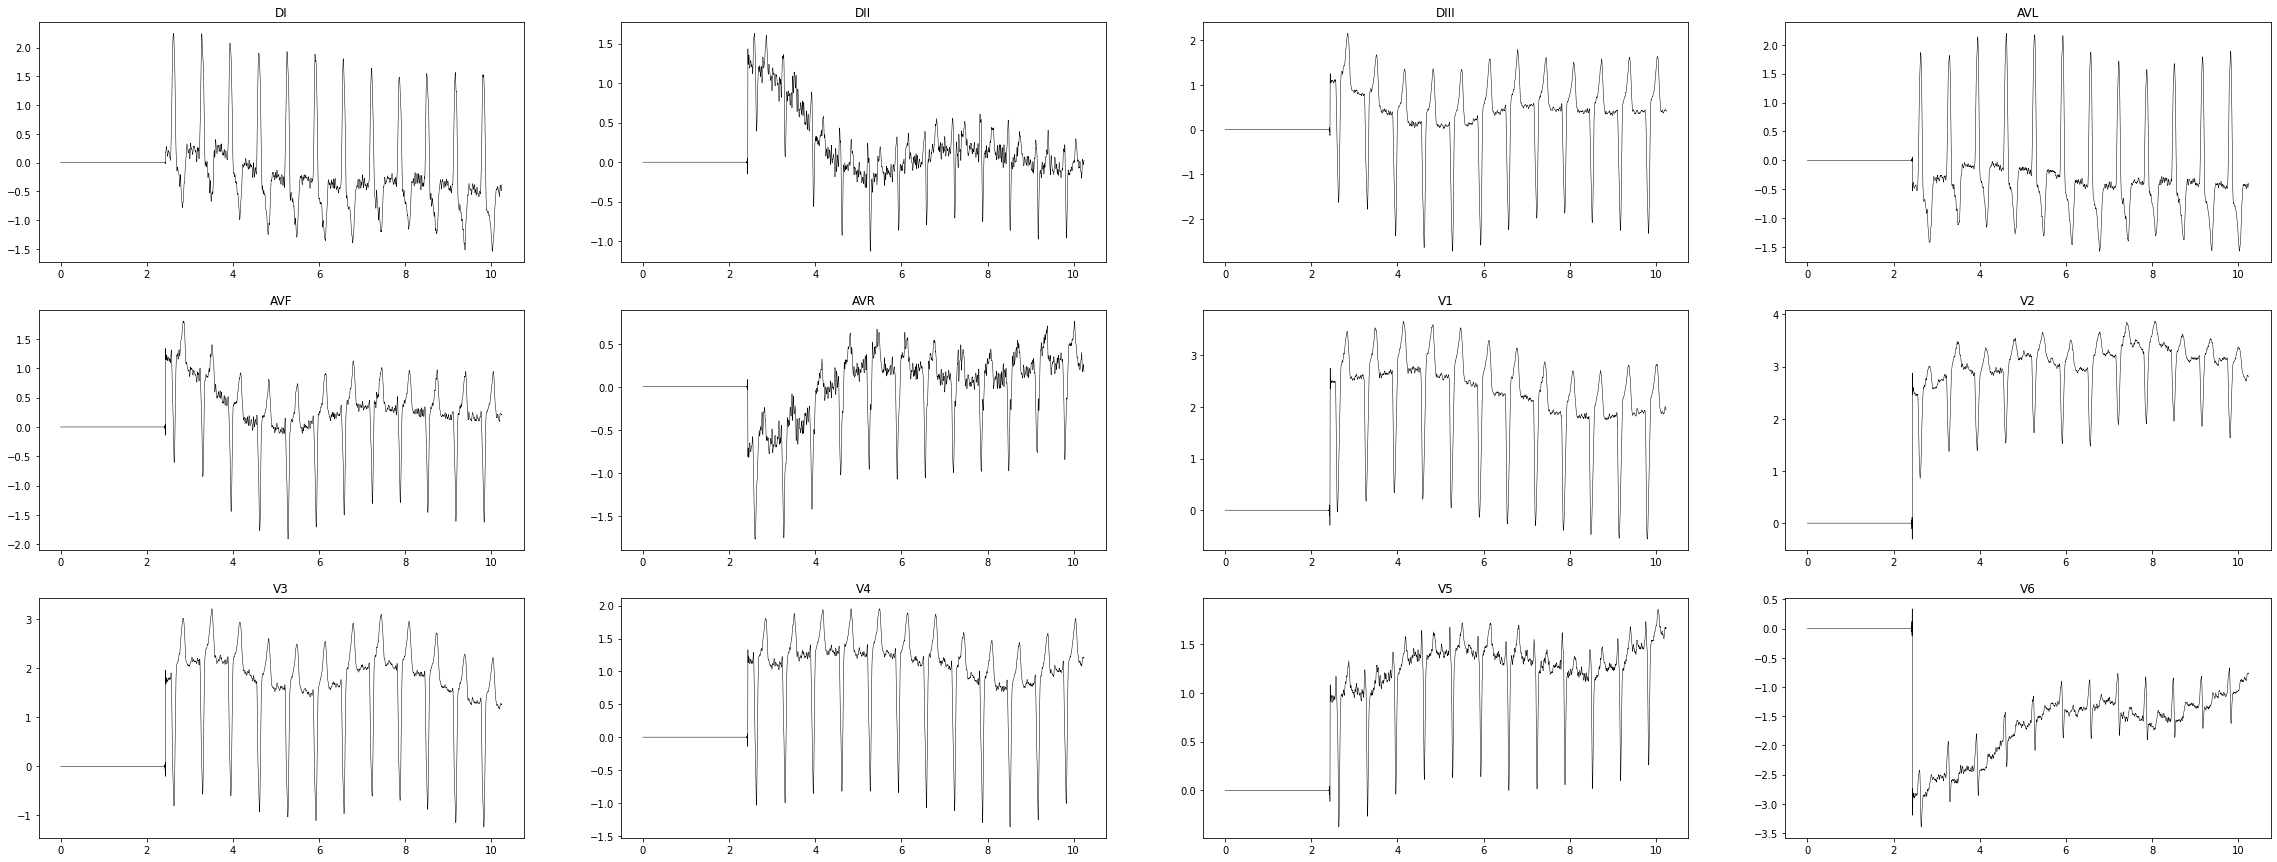

In [ ]:
fig, axs = plt.subplots(3, 4,figsize=(40,15))

for i in range(3):
    for j in range(4):
        ax = axs[i,j]
        ax.set_title(lead_order[j+i*4])
        ax.plot(np.linspace(0,10.24,4096),x[1,:,j+i*4],'k', linewidth=.5)

## 1.2/ Modèle de classification : 

Nous importons le modèle déjà pré-entrainé sur les données que nous venons de présenter

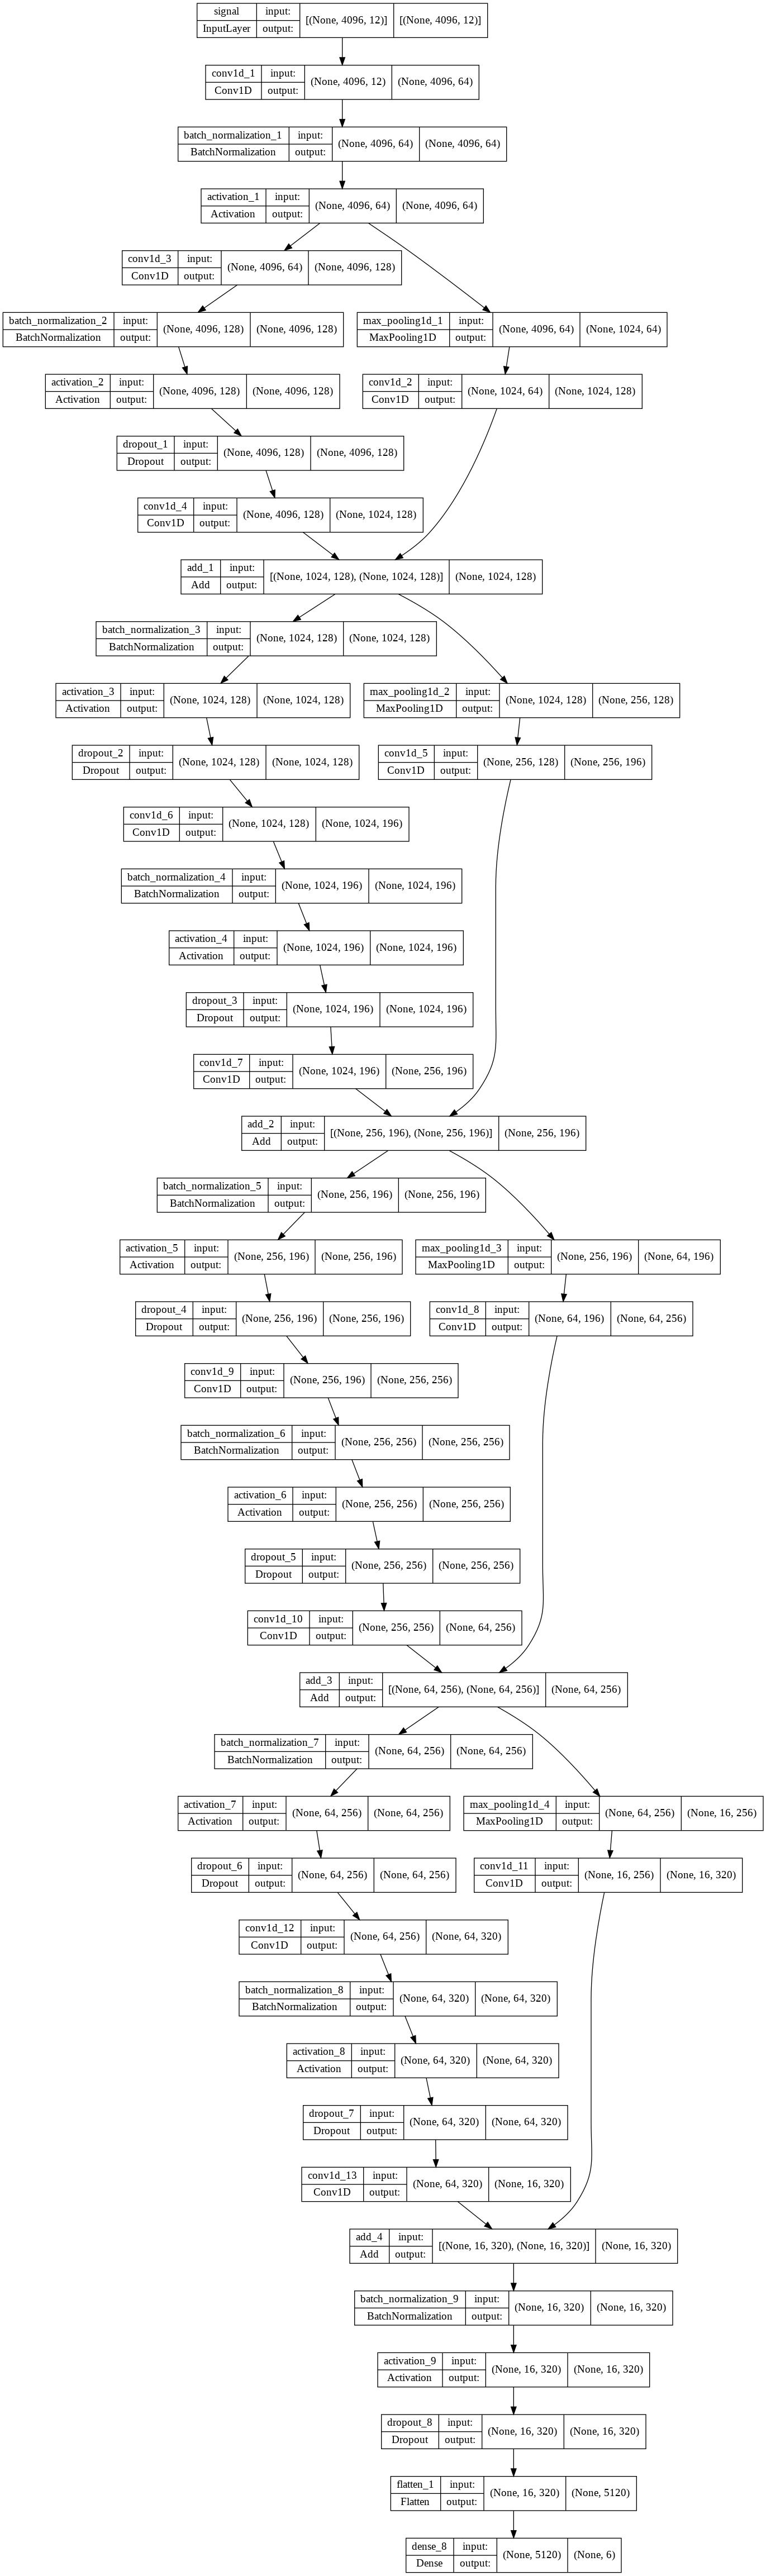

In [ ]:
model = load_model(f"/content/drive/MyDrive/Colab_Notebooks/model/model.hdf5", compile=False,)
model.compile(loss='binary_crossentropy', optimizer=Adam())

tf.keras.utils.plot_model(model,show_shapes=1)

La cellule suivante va nous permettre de visualiser 

In [ ]:
from keras import backend as k


def find_last_conv(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 3:
            return layer.name


def grad_cam(model, time_serie, class_index, relative=True): ##Visualize how parts of the image affects neural network's output by looking into the activation maps
  
    '''
  version img :
  https://github.com/sicara/tf-explain/blob/master/tf_explain/core/grad_cam.py
  '''
  
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(find_last_conv(model)).output, model.output])
    with tf.GradientTape() as tape: ## tf.GradientTape calcule le gradient en un point cf après avec tape
        inputs = tf.cast([time_serie], tf.float32) ## change le type de la valeurs
        conv_outputs, predictions = grad_model(inputs) ## Output du model
        loss = predictions[:, class_index] 

    
    grads = tape.gradient(loss, conv_outputs) 
    A = np.asarray(conv_outputs[0,:,:])
    dy = np.asarray(grads[0,:,:])
    a_k = dy.mean(axis=0)
    heat_map = np.sum(a_k*A, axis=1)
    heat_map = heat_map * (heat_map>0)
  
    if relative :
        heat_map /= heat_map.max()+1e-6
    return heat_map


from scipy.interpolate import interp1d

def plot_grad_cam_ecg(ts, check_y, selected_leads=True, relatives=True):
    hm = grad_cam(model, ts, check_y, relative=relatives)
    hm_interp = interp1d(np.linspace(0,10.24,16), hm, kind='slinear')
    if selected_leads:
        fig, axs = plt.subplots(1, 3,figsize=(40,5))
        for i,pos in enumerate([1,6,11]):
            ax = axs[i]
            ax.set_title(lead_order[pos],fontsize=10)
            ax.plot(np.linspace(0,10.24,4096),ts[:,pos],'k', linewidth=.5)
            t = ax.scatter(np.linspace(0,10.24,4096),ts[:,pos],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
        fig.colorbar(t,ax=axs)
        plt.show()
    
    else :
        fig, axs = plt.subplots(4, 3,figsize=(20,16))
        for i in range(12):
            ax = axs[i//3, i%3]
            ax.set_title(lead_order[i],fontsize=10)
            ax.plot(np.linspace(0,10.24,4096),ts[:,i],'k', linewidth=.5)
            t = ax.scatter(np.linspace(0,10.24,4096),ts[:,i],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
        fig.colorbar(t,ax=axs)
        plt.show()

print('Index des anomalies dans les vecteurs : \n')
for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-1]):
    print(abnormality,idx_abn)

print('-----------------------------------------------------------------\n')
print('Pour 3 patients différensts nous affichons 3 dérivations de son ECG : \n')    
k=1
for idx_safe in df_goldStandard[df_goldStandard.nb_abnormality==0].index[:3]:
    print('Patient'+str(k)+' : \n')
    fig, axs = plt.subplots(1, 3,figsize=(40,5))
    for i,pos in enumerate([1,6,11]):
        ax = axs[i]
        ax.set_title(lead_order[pos],fontsize=20)
        ax.plot(np.linspace(0,10.24,4096),x[idx_safe,:,pos],'k', linewidth=.5)
    k+=1  
    plt.show()

print('-----------------------------------------------------------------------------------')
  

for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-1]):
    ## On recense tout les idx ou il y a abnormality 
    index_abnormality = df_goldStandard[(df_goldStandard[abnormality]==1)&(df_goldStandard.nb_abnormality==1)].index 
    print(f'\n\n###########\t{abnormality}\t###########\n')
    ## On ne prend que les 3 premiers pour exemple de pred
    preds = model.predict(x[index_abnormality[:3]])
    for i, pos in enumerate(index_abnormality[:3]):
        np.set_printoptions(precision=2,suppress=True)
        print('Ground Truth : \n',df_goldStandard.iloc[pos])
        print('\n Prédiction du modèle : ', preds[i])

        print("Visualisation de l'importance de chaque partie de l'ECG pour la prédiction : ")
        plot_grad_cam_ecg(x[pos],check_y=idx_abn)


Output hidden; open in https://colab.research.google.com to view.

Sur la visualisation les heatmaps des ECG nous permettent de voir quelles zones de l'ECG entraîne une telle prédiction

## 1.3/ Test des performances du modèle 

Dans un premier temps nous allons étudier les performances du classifieur pour savoir si oui ou non il détecte une anomalie. Pour cela nous comparons tout simplement le vecteur de prédiction et le vecteur de ground truth. Si la somme d'un vecteur est supérieure à 0 alors il y a anomalie sinon il n'y en a pas.

Tout d'abord nous créons le vecteur contenant les prédictions et le vecteur binaire qui dit si oui ou non la prédiction contient une anomalie.

In [ ]:
y_hat = model.predict(x)
y_binary = (np.sum(np.round(y_hat,2),axis=1)>0).astype(int)

On créé ensuite une nouvelle colonne dans df_goldstandard relevant si oui ou non il y a présence d'anomalie.

In [ ]:
df_goldStandard['binary_anomalie'] = df_goldStandard['nb_abnormality'].map(lambda x : x>0).astype(int)

On peut ainsi afficher la matrice de confusion suivante : 

In [ ]:
pd.crosstab(y_binary,df_goldStandard['binary_anomalie'])

binary_anomalie,0,1
row_0,,
0,606,1
1,75,145


On constate que le modèle diagnostie correctement la présence ou non d'une anomalie dans 91% des cas. En ce qui concerne les erreurs on remarque que celui-ci se trompe beaucoup plus souvent en prédisant une anomalie qui n'existe pas plutôt qu'en prédisant un patient sain alors que celui-ci possède une anomalie. C'est donc une bonne chose puisque se tromper dans ce sens est bien moins grave que de se tromper dans l'autre dans notre contexte.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

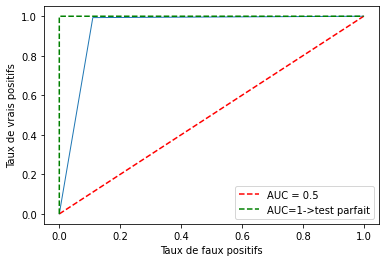

AUC: 0.9415092631705992


In [ ]:


fpr, tpr, thresholds = roc_curve(df_goldStandard['binary_anomalie'], y_binary)
plt.plot(fpr, tpr, lw=1)
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')

plt.plot([0,1],[0,1],'--r',label = 'AUC = 0.5')
plt.plot([0,0.000001,1],[0,1,1],'--g',label = 'AUC=1->test parfait')
plt.legend()

plt.show()
plt.show()

print("AUC: " + str(roc_auc_score(df_goldStandard['binary_anomalie'], y_binary)))

La courbe ROC et son score AUC associé nous indiquent que notre classifieur a de bonnes performances dans les prédictions

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


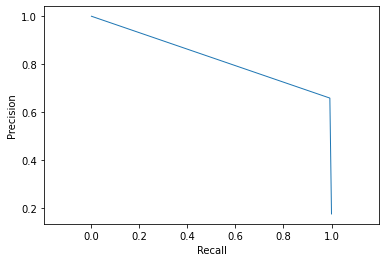

AUC: 0.6557857776385713


In [ ]:

pr, rec, thresholds = precision_recall_curve(df_goldStandard['binary_anomalie'], y_binary)
plt.plot(rec, pr, lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis('equal')
plt.show()

print("AUC: " + str(average_precision_score(df_goldStandard['binary_anomalie'], y_binary)))

La courbe Precision-Recall et son score AUC quant à elle nous indique que le classifieur a plus de mal sur les prédictions de classe minoritaire.

Pour chaque prédiction nous associerons à la prédiction la classe ayant la plus forte probabilité. Ex : Pour une prédiction [0,0.1,0,0.8,0.1,0] la classe associée sera la 4 (indice).

Nous allons déterminer le pourcentage de prédiction juste sur la partie test du dataset dans le cas où le patient n'a qu'une anormalités :

In [ ]:
cpt=0

for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-1]):
    ## On recense tout les idx ou il y a abnormality 
    index_abnormality = df_goldStandard[(df_goldStandard[abnormality]==1)&(df_goldStandard.nb_abnormality==1)].index 
    print(f'\n\n###########\t{abnormality}\t###########\n')
    preds = model.predict(x[index_abnormality])
    cpt2 = 0
    for i in range(preds.shape[0]):
        if(np.argmax(preds[i])==idx_abn):
            cpt+=1
            cpt2+=1
    print(abnormality +' est prédite à ',100*cpt2/len(index_abnormality), '% correctement')

print('\n\nAu total notre prédiction est correcte dans ',100*cpt/len(df_goldStandard[(df_goldStandard.nb_abnormality==1)]),'% des cas')   



###########	1dAVb	###########

1dAVb est prédite à  100.0 % correctement


###########	RBBB	###########

RBBB est prédite à  100.0 % correctement


###########	LBBB	###########

LBBB est prédite à  96.0 % correctement


###########	SB	###########

SB est prédite à  100.0 % correctement


###########	AF	###########

AF est prédite à  100.0 % correctement


###########	ST	###########

ST est prédite à  100.0 % correctement


###########	nb_abnormality	###########

nb_abnormality est prédite à  0.0 % correctement


Au total notre prédiction est correcte dans  99.25373134328358 % des cas


Observons maintenant les cas où le patient a plusieurs anormalités :

In [ ]:
for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-2]):
    index_abnormality = df_goldStandard[(df_goldStandard[abnormality]==1)&(df_goldStandard.nb_abnormality>1)].index 
    print(f'\n\n###########\t{abnormality}\t###########\n')
    preds = model.predict(x[index_abnormality])
    cpt2 = 0
    
    if(len(preds>0)):
        for i in range(preds.shape[0]):
            print('Prediction : ',preds[i],'/////  Ground truth : ',np.array(df_goldStandard.iloc[index_abnormality[i]][:6]))
            if(np.argmax(preds[i])==idx_abn):
                cpt+=1
                cpt2+=1
        print(abnormality +' est prédite à ',100*cpt2/len(index_abnormality), '% correctement')
    else:
        print('Pas de cas où il y a une deuxième anormalité avec '+abnormality)



###########	1dAVb	###########

Prediction :  [0.2  0.   0.69 0.   0.17 0.  ] /////  Ground truth :  [1 0 1 0 0 0]
Prediction :  [0.52 0.01 0.72 0.02 0.01 0.  ] /////  Ground truth :  [1 0 1 0 0 0]
Prediction :  [0.42 0.8  0.01 0.   0.   0.  ] /////  Ground truth :  [1 1 0 0 0 0]
Prediction :  [0.19 0.02 0.   0.71 0.   0.  ] /////  Ground truth :  [1 0 0 1 0 0]
Prediction :  [0.37 0.   0.6  0.   0.02 0.  ] /////  Ground truth :  [1 0 1 0 0 0]
Prediction :  [0.32 0.7  0.05 0.   0.02 0.  ] /////  Ground truth :  [1 1 0 0 0 0]
Prediction :  [0.35 0.66 0.03 0.   0.04 0.  ] /////  Ground truth :  [1 1 0 0 0 0]
Prediction :  [0.11 0.54 0.01 0.   0.12 0.  ] /////  Ground truth :  [1 1 0 0 0 0]
1dAVb est prédite à  0.0 % correctement


###########	RBBB	###########

Prediction :  [0.42 0.8  0.01 0.   0.   0.  ] /////  Ground truth :  [1 1 0 0 0 0]
Prediction :  [0.32 0.7  0.05 0.   0.02 0.  ] /////  Ground truth :  [1 1 0 0 0 0]
Prediction :  [0.   0.82 0.01 0.   0.82 0.  ] /////  Ground truth

# Partie 2 : Ribeiro model and transfer learning

L'objectif de cette partie est d'adapter le modèle de Ribeiro utilisé dans la première partie à un nouveau jeu de données possédant des caractéristiques différentes. En effet, ce dataset présente une étude d'ECG sur 4 anomalies possible là où le modèle de ribeiro était lui entrainé sur 6 anomalies possible.

Notre but est donc de réaliser du transfer learning en partant du modèle de ribeiro et en adaptant ses couches de classifications à notre nouveau dataset.

## 2.1 / Présentation du nouveau dataset

Un premier traitement des données a était réalisé en amont pour alléger la RAM nécessaire à ce notebook. Nous importons ces données via les lignes de codes suivantes :

In [ ]:
f = open('/content/drive/MyDrive/Colab_Notebooks/data_test.txt','rb')
X_test = load(f)
y_test = load(f)
f.close()

Pour des raisons de capacité mémoire RAM il a été choisi de travailler avec légérement plus de 11 000 données pour l'entraînement. 10000 d'entre elles sont purement réservées à l'apprentissage et les données restantes sont utilisées pour la validation. Les 10000 données restantes du dataset complet seront utilisés lors de la phase de test des modèles.

Sur ce notebook nous n'intégrons que les données de test car nous ne réaliserons pas d'entraînement.

La cellule ci-dessous adapte nos nouvelles données aux formats d'entrées du modèle de Ribeiro.

In [ ]:
#Define the diseases
diseases = ["NORM","MI","HYP","CD","STTC"]

#Create a RIBEIRO format training data
def Ribeiro_convert(y_test):
    
    y_test_ = list(y_test)

    y_test_ = [[0,0,0,0] for i in list(y_test)]
    for index, info in enumerate(y_test):

        for disease in info:

            if disease != 'NORM':
              y_test_[index][diseases.index(disease)-1] = 1

    y_test_ = np.array(y_test_)
    return y_test_

y_test_ = Ribeiro_convert(y_test)


def convert_X(X,scale):
    X_conv = np.empty((X.shape[0], 4096, 12))
    for index,array in enumerate(X):
        array = cv2.resize(array,(12,scale))
        X_conv[index,:,:]=array
    return X_conv
    
X_test_=convert_X(X_test,4096)    

del(X_test)
del(y_test)

with tf.device('/device:GPU:0'):
  X_test__ = tf.convert_to_tensor(X_test_)
  y_test__ = tf.convert_to_tensor(y_test_)

del(X_test_)
del(y_test_)

Comme pour le premier dataset nous pouvons afficher un exemple de données présentes dans le dataset. Cette visualisation est logiquement similaire à celle de la partie précédente car nous avons réalisé les transformations nécessaires sur les nouvelles données. 

Diagnostic gt :  tf.Tensor([0 0 1 0], shape=(4,), dtype=int64)


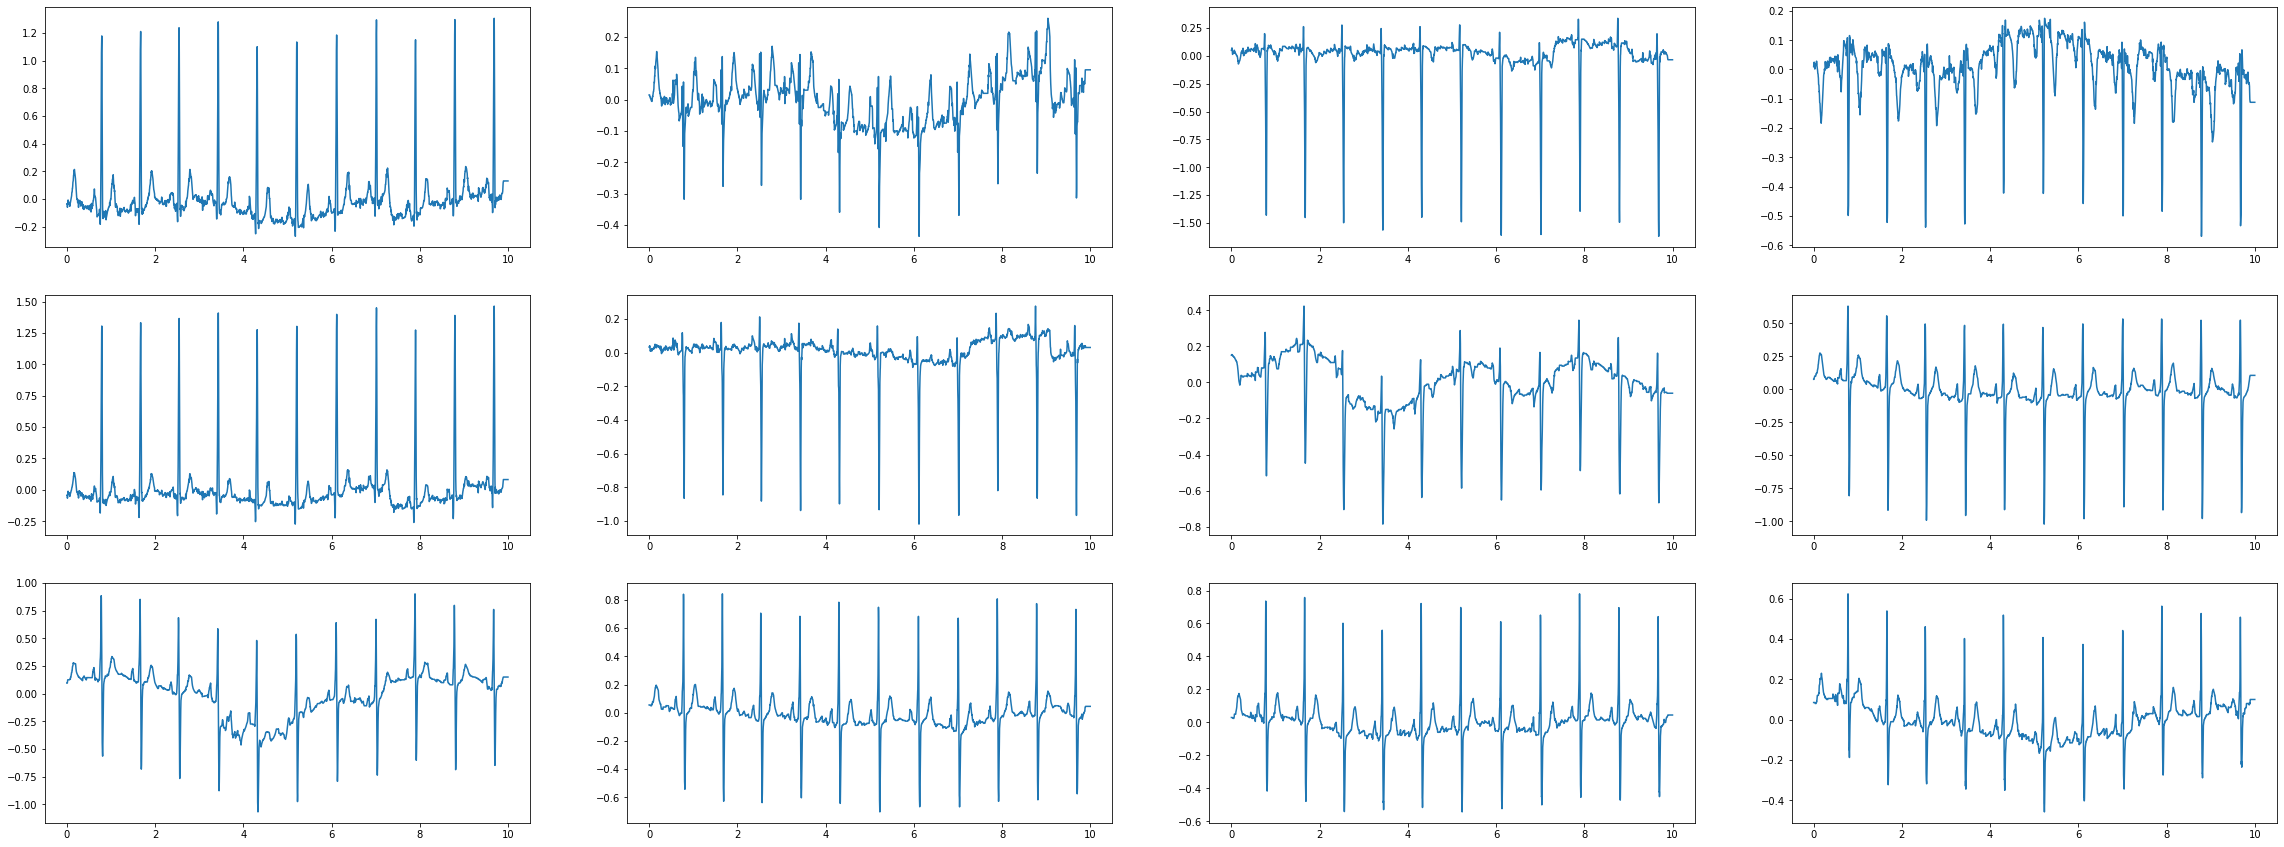

In [ ]:
abs = np.linspace(0,10,4096)
idx = np.random.randint(X_test__.shape[0])

fig, axs = plt.subplots(3, 4,figsize=(40,15))

for i in range(3):
  for j in range(4):
    axs[i,j].plot(abs,X_test__[idx,:,i*4+j])

print('Diagnostic gt : ', y_test__[idx])



## 2.2/ Entrainement des nouveaux modèles

In [ ]:
from IPython import display
from base64 import b64decode

Tout les entraînements qui seront présentés par la suite sont réalisés avec les propriétés suivantes :
  - Epochs : 50
  - Batch_size : 128
  - Seule la dernière couche du modèle de Ribeiro a été modifié
  - Fonction de perte : Binary cross-Entropie
  - Algorithme d'optimisation :  Adam avec pas de 10**-3
  - Taille des sets :
    - Entrainement : 10000
    - Validation : 1500
    - Test :10000



Nous nous inspirons donc du modèle suivant de Ribeiro pour nos entraînement. Seule la dernière couche dense est modifiée afin d'adapter la sortie du modèle à notre dataset.

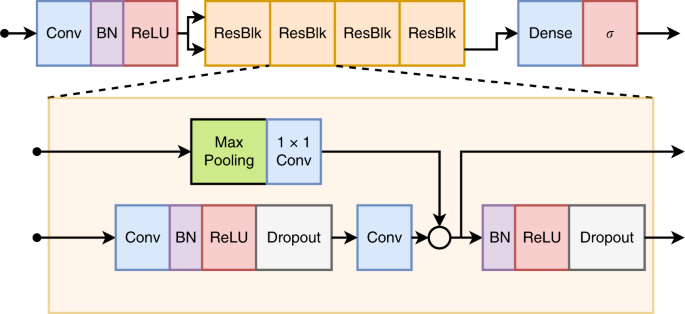

In [ ]:
display.Image('/content/drive/MyDrive/Colab_Notebooks/DocumentsRapport/ImageModelRibeiro.png')

Nous avons choisi d'entraîner 6 modèles différents sur les mêmes données en suivant le schéma suivant : 

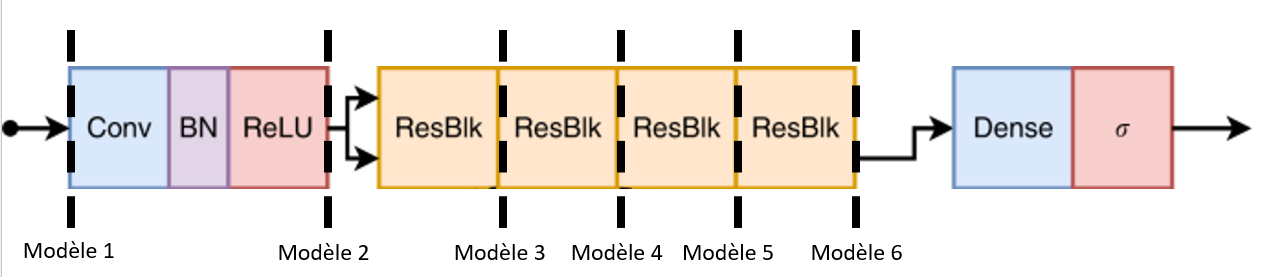

Ce schéma indique pour chaque modèle jusqu'à quelle couche nos gelons les poids précédemment appris par le modèle Ribeiro. Par exemple pour le modèle 1 notre modèle réapprend toutes les couches et le modèle 6 lui n'apprend que les couches de classifications.

Dans les parties suivantes nous présenterons donc chaque modèle en començant par afficher le déroulement de son entraînement puis en étudiant ses performances.

Pour l'évaluation de nos modèles nous utiliserons plusieurs méthodes définies par les fonctions ci-dessous : 
  - La première méthode est une méthode naïve qui prend uniquement en compte si oui ou non notre modèle prédit la présence d'une anomalie (même à faible probabilité). On affichera avec cette méthode la matrice de confusion.
  - La deuxième méthode (score_method1) consiste à arrondir les valeurs des classes données par le modèle. Nous obtenons donc, pour chaque prédiction et chaque classe, une valeur égale à 0 ou 1. Si la valeur 1 est associée à une classe on prédit une anomalie. 

  - La troisième méthode (score_method2), dans le cas où il y a une seule anomalie, associe la prédiction de la classe ayant la plus forte probabilité.

In [ ]:
def Score_method_binaire(preds,gt,ROC = 0,PR=0):
  preds = (np.sum(np.round(np.array(preds),2),axis=1)>0).astype(int)
  gt = (np.sum(np.round(np.array(gt),2),axis=1)>0).astype(int)
  print('Prediction accuracy : ',np.mean(preds==gt))

  if(ROC): 
    fpr, tpr, thresholds = roc_curve(gt, preds)
    plt.plot(fpr, tpr, lw=1)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.plot([0,1],[0,1],'--r',label = 'AUC = 0.5')
    plt.plot([0,0.000001,1],[0,1,1],'--g',label = 'AUC=1->test parfait')
    plt.legend()
    plt.show()

    print("AUC ROC: " + str(roc_auc_score(gt, preds)))

  if(PR):
    pr, rec, thresholds = precision_recall_curve(gt, preds)
    plt.plot(rec, pr, lw=1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis('equal')
    plt.show()

    print("AUC PR: " + str(average_precision_score(gt, preds)))

    print('La matrice de confusion : \n')
  return pd.crosstab(preds,gt)

def Score_method1(preds,gt):
  correct_detection=np.zeros(4)
  bad_detection=np.zeros(4)
  for n in range(len(preds[:,0])):
    for j in range(4):
      if round(preds[n,j])==gt[n,j] :
        correct_detection[j]+=1
      else :
        bad_detection[j]+=1
        
  print("Disease = MI, prediction correcte : "+str(100*correct_detection[0]/(correct_detection[0]+bad_detection[0]))+' %')
  print("Disease = HYP, prediction correcte : "+str(100*correct_detection[1]/(correct_detection[1]+bad_detection[1]))+' %')
  print("Disease = CD, prediction correcte : "+str(100*correct_detection[2]/(correct_detection[2]+bad_detection[2]))+' %')
  print("Disease = STTC, prediction correcte : "+str(100*correct_detection[3]/(correct_detection[3]+bad_detection[3]))+' %')


def Score_method2(preds,gt):
  bad_detection=np.zeros(4)
  correct_detection=np.zeros(4)
  for n in range(len(preds[:,0])):
      if np.sum(gt[n,:])==1 :    #une seule anomalie
          if gt[n,np.argmax(preds[n,:])]==1 :
              correct_detection[np.argmax(preds[n,:])]+=1
          else :
              bad_detection[np.argmax(preds[n,:])]+=1

  print("Disease = MI, prediction correcte : "+str(100*correct_detection[0]/(correct_detection[0]+bad_detection[0]))+' %')
  print("Disease = HYP, prediction correcte : "+str(100*correct_detection[1]/(correct_detection[1]+bad_detection[1]))+' %')
  print("Disease = CD, prediction correcte : "+str(100*correct_detection[2]/(correct_detection[2]+bad_detection[2]))+' %')
  print("Disease = STTC, prediction correcte : "+str(100*correct_detection[3]/(correct_detection[3]+bad_detection[3]))+' %')




Passons maintenant à la phase de test de nos modèles : 

## 2.3/ Modèle 1

Le 1er modèle apprend toutes les couches

In [ ]:
model1 = load_model(f"/content/drive/MyDrive/Colab_Notebooks/model/Modele1/model1", compile=True)

f = open('/content/drive/MyDrive/Colab_Notebooks/model/Modele1/model1_history.txt','rb')
history = load(f)
f.close()

Pour commencer voici l'évolution de la loss durant l'entraînement sur les set de train et de validation : 

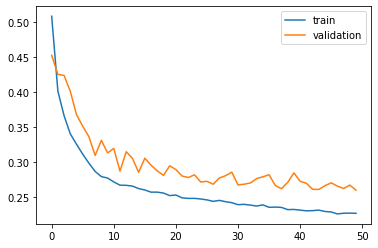

In [ ]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'validation')
plt.legend()
plt.show()

Calculons les prédictions sur le dataset de test pour ce modèle : 

In [ ]:
with tf.device('/device:GPU:0'):
  preds_model1 = model1.predict(X_test__)

On calcul ensuite les scores de ces prédictions avec les différentes méthodes détaillées plus haut

Prediction accuracy :  0.6958884445811545


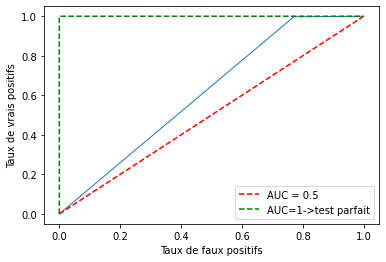

AUC ROC: 0.6133773130695871


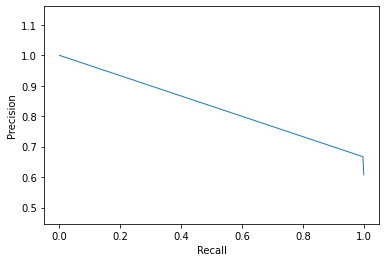

AUC PR: 0.6668721915442555
La matrice de confusion : 



col_0,0,1
row_0,,
0,879,17
1,2949,5908


In [ ]:
Score_method_binaire(preds_model1,y_test__,ROC=1,PR=1)

In [ ]:
Score_method1(preds_model1,y_test__)

Disease = MI, prediction correcte : 87.66533374346355 %
Disease = HYP, prediction correcte : 91.45903824464267 %
Disease = CD, prediction correcte : 90.40295293755767 %
Disease = STTC, prediction correcte : 86.97836563108787 %


In [ ]:
Score_method2(preds_model1,y_test__)

Disease = MI, prediction correcte : 85.39156626506023 %
Disease = HYP, prediction correcte : 67.90123456790124 %
Disease = CD, prediction correcte : 86.73366834170854 %
Disease = STTC, prediction correcte : 81.11313868613139 %


In [ ]:
del(preds_model1)
del(model1)

## 2.4/ Modèle 2

On va ensuite tester le deuxième modèle.

In [ ]:
model2 = load_model(f"/content/drive/MyDrive/Colab_Notebooks/model/Modele2/model2", compile=True)

f = open('/content/drive/MyDrive/Colab_Notebooks/model/Modele2/model2_history.txt','rb')
history = load(f)
f.close()

On présente ensuite l'évolution de la loss sur le train et la validation

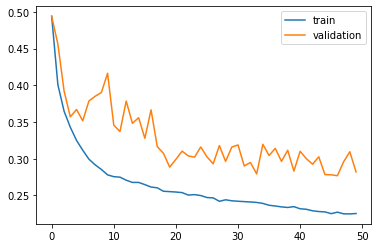

In [ ]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'validation')
plt.legend()
plt.show()

Ensuite on réalise la prédiction des dataset de test avec ce modèle.

In [ ]:
with tf.device('/device:GPU:0'):
  preds_model2 = model2.predict(X_test__)

Puis on calcul les scores avec les différentes méthodes

Prediction accuracy :  0.7345432174715473


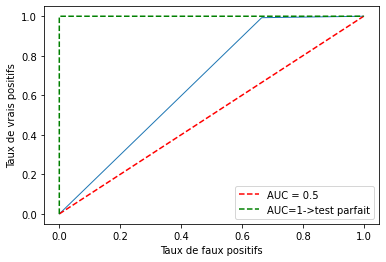

AUC ROC: 0.6638216737431055


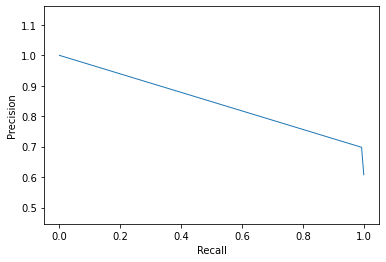

AUC PR: 0.69725560930725
La matrice de confusion : 



col_0,0,1
row_0,,
0,1282,43
1,2546,5882


In [ ]:
Score_method_binaire(preds_model2,y_test__,ROC=1,PR=1)

In [ ]:
Score_method1(preds_model2,y_test__)

Disease = MI, prediction correcte : 87.32697631498 %
Disease = HYP, prediction correcte : 91.60258382036297 %
Disease = CD, prediction correcte : 90.13636829693428 %
Disease = STTC, prediction correcte : 86.8143135445504 %


In [ ]:
Score_method2(preds_model2,y_test__)

Disease = MI, prediction correcte : 87.19172633253778 %
Disease = HYP, prediction correcte : 74.28571428571429 %
Disease = CD, prediction correcte : 82.50235183443085 %
Disease = STTC, prediction correcte : 80.12367491166077 %


In [ ]:
del(preds_model2)
del(model2)

## 2.5/ Modèle 3

On va ensuite tester le troisième modèle

In [ ]:
model3 = load_model(f"/content/drive/MyDrive/Colab_Notebooks/model/Modele3/model3", compile=True)

f = open('/content/drive/MyDrive/Colab_Notebooks/model/Modele3/model3_history.txt','rb')
history = load(f)
f.close()

On affiche l'évolution de la loss sur le train et validation

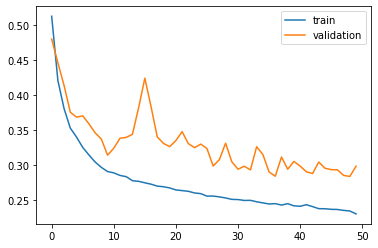

In [ ]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'validation')
plt.legend()
plt.show()

On réalise les prédictions sur le dataset de test

In [ ]:
with tf.device('/device:GPU:0'):
  preds_model3 = model3.predict(X_test__)

Et on calcul les scores avec les différentes méthodes

Prediction accuracy :  0.7532041423151851


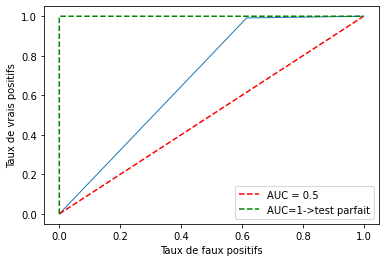

AUC ROC: 0.6879637051439758


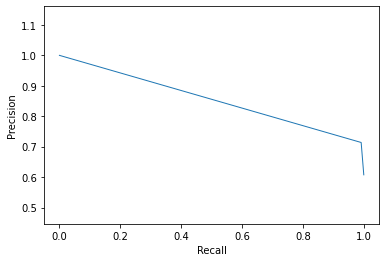

AUC PR: 0.7128159144918902
La matrice de confusion : 



col_0,0,1
row_0,,
0,1472,51
1,2356,5874


In [ ]:
Score_method_binaire(preds_model3,y_test__,ROC=1,PR=1)

In [ ]:
Score_method1(preds_model3,y_test__)

Disease = MI, prediction correcte : 85.98379985645443 %
Disease = HYP, prediction correcte : 91.16169383779349 %
Disease = CD, prediction correcte : 90.26966061724598 %
Disease = STTC, prediction correcte : 86.43494309443248 %


In [ ]:
Score_method2(preds_model3,y_test__)

Disease = MI, prediction correcte : 86.522462562396 %
Disease = HYP, prediction correcte : 74.21052631578948 %
Disease = CD, prediction correcte : 81.19738072965389 %
Disease = STTC, prediction correcte : 76.85262281432139 %


In [ ]:
del(preds_model3)
del(model3)

## 2.6/ Modèle 4

On va ensuite tester le quatrième modèle

In [ ]:
model4 = load_model(f"/content/drive/MyDrive/Colab_Notebooks/model/Modele4/model4", compile=True)

f = open('/content/drive/MyDrive/Colab_Notebooks/model/Modele4/model4_history.txt','rb')
history = load(f)
f.close()

On affiche l'évolution de la loss 

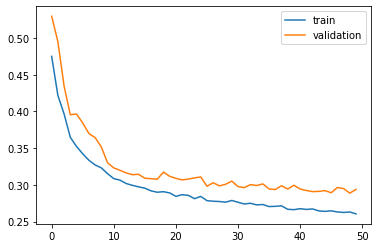

In [ ]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'validation')
plt.legend()
plt.show()

On réalise les prédictions sur le dataset de test

In [ ]:
with tf.device('/device:GPU:0'):
  preds_model4 = model4.predict(X_test__)

Et finalement on calcul les scores sur les prédictions

Prediction accuracy :  0.6232953962883215


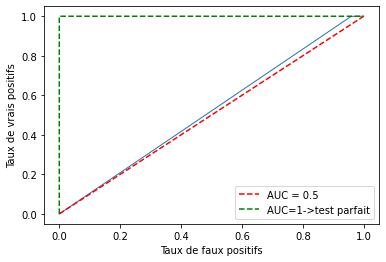

AUC ROC: 0.5202536275015541


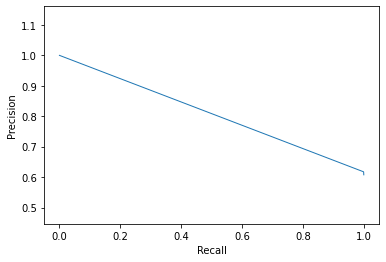

AUC PR: 0.6173201608841219
La matrice de confusion : 



col_0,0,1
row_0,,
0,157,3
1,3671,5922


In [ ]:
Score_method_binaire(preds_model4,y_test__,ROC=1,PR=1)

In [ ]:
Score_method1(preds_model4,y_test__)

Disease = MI, prediction correcte : 83.71783041115555 %
Disease = HYP, prediction correcte : 90.91561570798729 %
Disease = CD, prediction correcte : 88.89572439249461 %
Disease = STTC, prediction correcte : 86.36317030657234 %


In [ ]:
Score_method2(preds_model4,y_test__)

Disease = MI, prediction correcte : 88.7410440122825 %
Disease = HYP, prediction correcte : 52.06349206349206 %
Disease = CD, prediction correcte : 82.51256281407035 %
Disease = STTC, prediction correcte : 69.6 %


In [ ]:
del(preds_model4)
del(model4)

## 2.7/ Modèle 5


On va ensuite tester le cinquième modèle

In [ ]:
model5 = load_model(f"/content/drive/MyDrive/Colab_Notebooks/model/Modele5/model5", compile=True)

f = open('/content/drive/MyDrive/Colab_Notebooks/model/Modele5/model5_history.txt','rb')
history = load(f)
f.close()

On affiche l'évolution de la loss

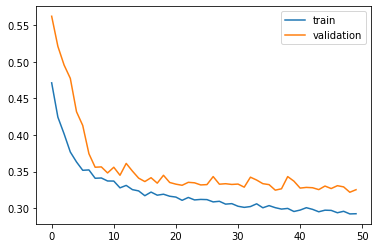

In [ ]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'validation')
plt.legend()
plt.show()

On calcul les prédictions sur le dataset de test

In [ ]:
with tf.device('/device:GPU:0'):
  preds_model5 = model5.predict(X_test__)

On calcul les scores sur les prédictions

Prediction accuracy :  0.6246283194914385


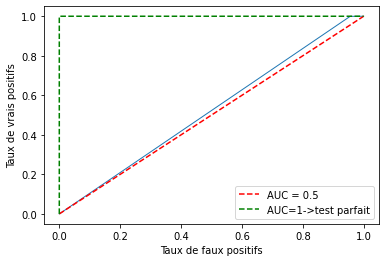

AUC ROC: 0.5219516421306033


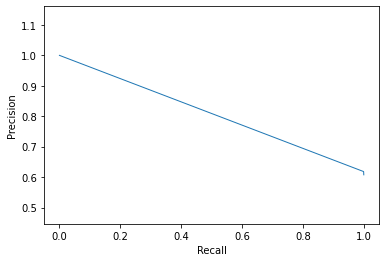

AUC PR: 0.6181574430680347
La matrice de confusion : 



col_0,0,1
row_0,,
0,170,3
1,3658,5922


In [ ]:
Score_method_binaire(preds_model5,y_test__,ROC=1,PR=1)

In [ ]:
Score_method1(preds_model5,y_test__)

Disease = MI, prediction correcte : 81.02122423869578 %
Disease = HYP, prediction correcte : 89.86978365631087 %
Disease = CD, prediction correcte : 88.50610068696811 %
Disease = STTC, prediction correcte : 84.8354352506921 %


In [ ]:
Score_method2(preds_model5,y_test__)

Disease = MI, prediction correcte : 76.9162210338681 %
Disease = HYP, prediction correcte : 54.017857142857146 %
Disease = CD, prediction correcte : 75.13711151736746 %
Disease = STTC, prediction correcte : 70.45826513911621 %


In [ ]:
del(preds_model5)
del(model5)

## 2.8/ Modèle 6

On test finalement le dernier modèle 

In [ ]:
model6 = load_model(f"/content/drive/MyDrive/Colab_Notebooks/model/Modele6/model6", compile=True)

f = open('/content/drive/MyDrive/Colab_Notebooks/model/Modele6/model6_history.txt','rb')
history = load(f)
f.close()

On affiche l'évolution de la loss

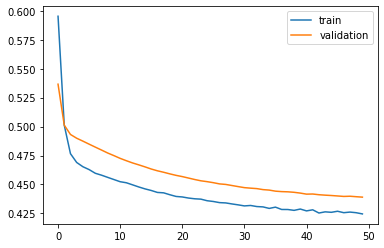

In [ ]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'validation')
plt.legend()
plt.show()

On réalise les prédictions sur le dataset

In [ ]:
with tf.device('/device:GPU:0'):
  preds_model6 = model6.predict(X_test__)

Et on calcul enfin les scores sur les prédictions

Prediction accuracy :  0.6075053829590895


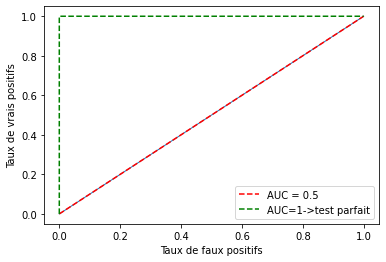

AUC ROC: 0.5


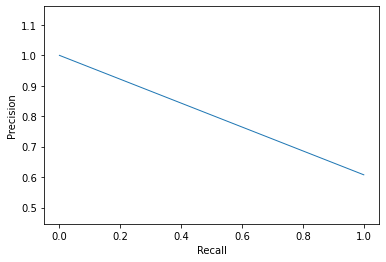

AUC PR: 0.6075053829590895
La matrice de confusion : 



col_0,0,1
row_0,,
1,3828,5925


In [ ]:
Score_method_binaire(preds_model6,y_test__,ROC=1,PR=1)

In [ ]:
Score_method1(preds_model6,y_test__)

Disease = MI, prediction correcte : 71.97785296831744 %
Disease = HYP, prediction correcte : 87.43976212447453 %
Disease = CD, prediction correcte : 86.04531938890598 %
Disease = STTC, prediction correcte : 77.07372090638778 %


In [ ]:
Score_method2(preds_model6,y_test__)

Disease = MI, prediction correcte : 54.11764705882353 %
Disease = HYP, prediction correcte : 50.0 %
Disease = CD, prediction correcte : 69.64933494558646 %
Disease = STTC, prediction correcte : 44.89795918367347 %


## 2.9/ Conclusion
Les résultats obtenus à partir de l'échantillon test pour les modèles 1, 2 et 3 sont plutôt bons. Réapprendre les trois couches : Convolution, Batch normalisation, et ReLu n'améliore pas énormément les résultats. 

On constate une nette dégradation de la qualité des prédictions pour les modèles 4, 5 et 6. 

Le temps de calcul est aussi à prendre en compte,  le modèle 3 est donc le meilleur compromis entre qualité des prédictions et le temps que l'on met à entrainer le modèle. 